# Apply Decision Trees on Donors Choose dataset

In [1]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
import pandas as pd
data = pd.read_csv('preprocessed_data.csv', nrows=50000)

# 1. calculate sentiment scores for the essay feature 

In [2]:
# Import necessary modules
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# obtain the 'compound' sentiment score of each text 
# Storing it in new column 'compound_sentiment_score'
data['compound_sentiment_score'] = [sid.polarity_scores(text)['compound'] for text in data['essay']]

# 2. Split your data.

In [3]:
y = data['project_is_approved'] 
X = data.drop(['project_is_approved'], axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# 3. perform tfidf vectorization of text data. preprocessed_essay (TFIDF)

In [4]:
# Import the TfidfVectorizer module from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer with the specified parameters
vectorizer_essay = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=5000) ## min_df: the minimum frequency of a word in the corpus required to be included in the vectorization

# Fit the vectorizer to the 'essay' column of the training data X_train
# This transforms the 'essay' column into a sparse matrix of TF-IDF weighted features
X_train_essay_tfidf = vectorizer_essay.fit_transform(X_train['essay'])

# Transform the 'essay' column of the validation data X_cv and test data X_test into the same TF-IDF sparse matrix using the fitted vectorizer from the training data
X_cv_essay_tfidf = vectorizer_essay.transform(X_cv['essay'])
X_test_essay_tfidf = vectorizer_essay.transform(X_test['essay'])

# Print the shapes of the resulting sparse matrices of TF-IDF vectors for each dataset
print(f"After vectorizations:\n{X_train_essay_tfidf.shape}, {y_train.shape}\n{X_cv_essay_tfidf.shape}, {y_cv.shape}\n{X_test_essay_tfidf.shape}, {y_test.shape}\n{'='*100}")

After vectorizations:
(22445, 5000), (22445,)
(11055, 5000), (11055,)
(16500, 5000), (16500,)


# 4. perform tfidf w2v vectorization of text data.

In [5]:
import pickle
from tqdm import tqdm
import numpy as np

# storing variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

# initialize TfidfVectorizer
tfidf_model = TfidfVectorizer()

# fit the model on essay
tfidf_model.fit(X_train['essay'])

# create a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names_out(), list(tfidf_model.idf_)))

# get the set of words in tfidf_model
tfidf_words = set(tfidf_model.get_feature_names_out())

def get_tfidf_w2v_vectors(data):
    tfidf_w2v_vectors = []
    for sentence in tqdm(data['essay']):
        vector = np.zeros(300)
        tf_idf_weight = 0
        words = set(sentence.split())
        common_words = glove_words.intersection(words)
        for word in common_words.intersection(tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word] * (sentence.count(word) / len(words))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

# Get the TF-IDF weighted word2vec vectors for each dataset
tfidf_w2v_vectors_train = get_tfidf_w2v_vectors(X_train)
tfidf_w2v_vectors_cv = get_tfidf_w2v_vectors(X_cv)
tfidf_w2v_vectors_test = get_tfidf_w2v_vectors(X_test)

# check the dimensions of the vectors
print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|██████████| 16500/16500 [00:07<00:00, 2296.95it/s]

22445
300


# 5. perform encoding of categorical features.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_features(train, cv, test, feature):
    
    # Initialize CountVectorizer with optimized parameters
    vectorizer = CountVectorizer(binary=True, max_features=5000, ngram_range=(1,2))
    
    # Fit the vectorizer on the training data
    vectorizer.fit(train[feature].values)
    
    # Transform the categorical features into one-hot encoded features
    train_ohe = vectorizer.transform(train[feature].values)
    cv_ohe = vectorizer.transform(cv[feature].values)
    test_ohe = vectorizer.transform(test[feature].values)
    
    # Print the shape and feature names for each of the transformed datasets
    print("After vectorizations")
    print(train_ohe.shape, y_train.shape)
    print(cv_ohe.shape, y_cv.shape)
    print(test_ohe.shape, y_test.shape)
    print(vectorizer.get_feature_names_out())
    print("="*100)
    
    # Return the one-hot encoded features
    return train_ohe, cv_ohe, test_ohe, vectorizer.get_feature_names_out()

# Vectorizing categorical data
X_train_state_ohe, X_cv_state_ohe, X_test_state_ohe, features_school_state = vectorize_features(X_train, X_cv, X_test, 'school_state')
X_train_teacher_ohe, X_cv_teacher_ohe, X_test_teacher_ohe, features_teacher_prefix = vectorize_features(X_train, X_cv, X_test, 'teacher_prefix')
X_train_grade_ohe, X_cv_grade_ohe, X_test_grade_ohe, features_project_grade_category = vectorize_features(X_train, X_cv, X_test, 'project_grade_category')

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'ia' 'id'
 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms' 'mt' 'nc'
 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy']
After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['dr' 'mr' 'mrs' 'ms' 'teacher']
After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5' 'grades_6_8' 'grades_9_12' 'grades_prek_2']


In [7]:
from collections import Counter

# Count the frequency of words in the 'clean_categories' column- https://stackoverflow.com/a/22898595/4084039
category_counts = Counter(data['clean_categories'].str.split().sum())

# Sort the dictionary by value -https://stackoverflow.com/a/613218/4084039
sorted_categories = dict(sorted(category_counts.items(), key=lambda kv: kv[1]))

# Initialize CountVectorizer
vectorizer_categories = CountVectorizer(vocabulary=list(sorted_categories.keys()), lowercase=False, binary=True, max_features=100, min_df=10)

# Fit and transform the training data
X_train_category_ohe = vectorizer_categories.fit_transform(X_train['clean_categories'])

# Transform the validation and test data using the same vocabulary
X_cv_category_ohe = vectorizer_categories.transform(X_cv['clean_categories'])
X_test_category_ohe = vectorizer_categories.transform(X_test['clean_categories'])

# Print the resulting dimensions and feature names
print("After vectorization")
print(X_train_category_ohe.shape, y_train.shape)
print(X_cv_category_ohe.shape, y_cv.shape)
print(X_test_category_ohe.shape, y_test.shape)
print(vectorizer_categories.get_feature_names_out())
print("="*100)

After vectorization
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
['warmth' 'care_hunger' 'history_civics' 'music_arts' 'appliedlearning'
 'specialneeds' 'health_sports' 'math_science' 'literacy_language']


In [8]:
# Count the frequency of words in the 'clean_subcategories' column- https://stackoverflow.com/a/22898595/4084039
subcategory_counts = Counter(data['clean_subcategories'].str.split().sum())

# Sort the dictionary by value -https://stackoverflow.com/a/613218/4084039
sorted_subcategories = dict(sorted(subcategory_counts.items(), key=lambda kv: kv[1]))

# Initialize CountVectorizer
vectorizer_subcategories = CountVectorizer(vocabulary=list(sorted_subcategories.keys()), lowercase=False, binary=True, max_features=100, min_df=10)

# Fit and transform the training data
X_train_subcategory_ohe = vectorizer_subcategories.fit_transform(X_train['clean_subcategories'])

# Transform the validation and test data using the same vocabulary
X_cv_subcategory_ohe = vectorizer_subcategories.transform(X_cv['clean_subcategories'])
X_test_subcategory_ohe = vectorizer_subcategories.transform(X_test['clean_subcategories'])

# Print the resulting dimensions and feature names
print("After vectorization")
print(X_train_subcategory_ohe.shape, y_train.shape)
print(X_cv_subcategory_ohe.shape, y_cv.shape)
print(X_test_subcategory_ohe.shape, y_test.shape)
print(vectorizer_subcategories.get_feature_names_out())
print("="*100)

After vectorization
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)
['warmth' 'care_hunger' 'financialliteracy' 'economics'
 'parentinvolvement' 'communityservice' 'extracurricular'
 'foreignlanguages' 'civics_government' 'performingarts' 'teamsports'
 'socialsciences' 'charactereducation' 'nutritioneducation'
 'college_careerprep' 'other' 'music' 'history_geography' 'esl'
 'health_lifescience' 'earlydevelopment' 'environmentalscience'
 'visualarts' 'gym_fitness' 'appliedsciences' 'specialneeds'
 'health_wellness' 'literature_writing' 'mathematics' 'literacy']


# 6. perform encoding of numerical features

In [9]:
from sklearn.preprocessing import Normalizer

# Normalize price column
normalizer_price = Normalizer(norm='l1')

# doing .reshape(-1,1) to convert the 1D array of shape (n_samples,) to a 2D array of shape (n_samples, 1) 
# so that we can pass it as input to the Normalizer transformer.
normalizer_price.fit(X_train['price'].values.reshape(-1,1))

X_train_price_normalized = normalizer_price.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_normalized = normalizer_price.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_normalized = normalizer_price.transform(X_test['price'].values.reshape(-1,1))

# Normalize teacher_number_of_previously_posted_projects column
normalizer_prev_projects = Normalizer(norm='l1') 
normalizer_prev_projects.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_prev_projects_normalized = normalizer_prev_projects.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prev_projects_normalized = normalizer_prev_projects.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_projects_normalized = normalizer_prev_projects.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

# Print shapes of normalized features
print("After vectorizations")
print(X_train_price_normalized.shape, y_train.shape)
print(X_cv_price_normalized.shape, y_cv.shape)
print(X_test_price_normalized.shape, y_test.shape)
print("="*100)
print(X_train_prev_projects_normalized.shape, y_train.shape)
print(X_cv_prev_projects_normalized.shape, y_cv.shape)
print(X_test_prev_projects_normalized.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the 'compound_sentiment_score' column
train_normalized_sentiment_scores = scaler.fit_transform(X_train['compound_sentiment_score'].values.reshape(-1,1))
validation_normalized_sentiment_scores = scaler.fit_transform(X_cv['compound_sentiment_score'].values.reshape(-1,1))
test_normalized_sentiment_scores = scaler.fit_transform(X_test['compound_sentiment_score'].values.reshape(-1,1))

# Print shapes of normalized features
print("After vectorizations")
print(train_normalized_sentiment_scores.shape, y_train.shape)
print(validation_normalized_sentiment_scores.shape, y_cv.shape)
print(test_normalized_sentiment_scores.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


# 7. For task 1 set 1 stack up all the features

### Set 1: categorical, numerical features + preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)

In [11]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_set1 = hstack((X_train_essay_tfidf, X_train_category_ohe, X_train_subcategory_ohe, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_prev_projects_normalized, X_train_price_normalized, train_normalized_sentiment_scores)).tocsr()
X_cv_set1 = hstack((X_cv_essay_tfidf, X_cv_category_ohe, X_cv_subcategory_ohe, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_prev_projects_normalized, X_cv_price_normalized, validation_normalized_sentiment_scores)).tocsr()
X_test_set1 = hstack((X_test_essay_tfidf, X_test_category_ohe, X_test_subcategory_ohe, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_prev_projects_normalized, X_test_price_normalized, test_normalized_sentiment_scores)).tocsr()

print("Final Data matrix")
print(X_train_set1.shape, y_train.shape)
print(X_cv_set1.shape, y_cv.shape)
print(X_test_set1.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 5102) (22445,)
(11055, 5102) (11055,)
(16500, 5102) (16500,)


### Set 2: categorical, numerical features + preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)

In [12]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039

X_train_set2 = hstack((tfidf_w2v_vectors_train, X_train_category_ohe, X_train_subcategory_ohe, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_prev_projects_normalized, X_train_price_normalized, train_normalized_sentiment_scores)).tocsr()
X_cv_set2 = hstack((tfidf_w2v_vectors_cv, X_cv_category_ohe, X_cv_subcategory_ohe, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_prev_projects_normalized, X_cv_price_normalized, validation_normalized_sentiment_scores)).tocsr()
X_test_set2 = hstack((tfidf_w2v_vectors_test, X_test_category_ohe, X_test_subcategory_ohe, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_prev_projects_normalized, X_test_price_normalized, test_normalized_sentiment_scores)).tocsr()

print("Final Data matrix")
print(X_train_set1.shape, y_train.shape)
print(X_cv_set1.shape, y_cv.shape)
print(X_test_set1.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 5102) (22445,)
(11055, 5102) (11055,)
(16500, 5102) (16500,)


# 9. Perform hyperparameter tuning and plot either heatmap or 3d plot.


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]}

# Create a decision tree classifier object
dt_clf = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True)

# Fit the grid search object to the data
grid_search.fit(X_train_set1, y_train)

# Print the best hyperparameters and corresponding AUC score
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
print("Best AUC score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 10, 'min_samples_split': 500}
Best AUC score: 0.5860646417991389


Here, I used only the training set X_train and y_train to fit the model, and did not use a separate validation set X_cv_set1 during training. 

Because GridSearchCV internally split the training set into multiple folds and use each fold as the validation set i.e. the model is trained on a subset of the training data (using X_train) and validated on a different subset of the training data

In [14]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.612793,0.027661,0.012513,0.006257,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
1,0.623684,0.034752,0.014292,0.002850,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
2,0.410538,0.152746,0.006767,0.004125,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
3,0.275028,0.013903,0.004612,0.000782,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
4,0.754087,0.009958,0.005069,0.000818,3,5,"{'max_depth': 3, 'min_samples_split': 5}",0.575802,0.578841,0.583646,...,0.580668,0.003246,4,0.599836,0.591271,0.593395,0.589528,0.584550,0.591716,0.005002
5,0.723350,0.026846,0.005220,0.001160,3,10,"{'max_depth': 3, 'min_samples_split': 10}",0.575802,0.578841,0.583646,...,0.580668,0.003246,4,0.599836,0.591271,0.593395,0.589528,0.584550,0.591716,0.005002
6,0.703537,0.015404,0.005359,0.000482,3,100,"{'max_depth': 3, 'min_samples_split': 100}",0.575802,0.578841,0.583646,...,0.580562,0.003265,6,0.599836,0.591271,0.593395,0.589528,0.583960,0.591598,0.005173
7,0.682705,0.010907,0.004401,0.001020,3,500,"{'max_depth': 3, 'min_samples_split': 500}",0.576515,0.578822,0.583602,...,0.580674,0.003034,3,0.599770,0.590971,0.593307,0.589197,0.583960,0.591441,0.005178
8,2.885443,0.313049,0.005037,0.000044,10,5,"{'max_depth': 10, 'min_samples_split': 5}",0.554691,0.575164,0.587736,...,0.572829,0.012440,9,0.663439,0.662416,0.652509,0.654913,0.646455,0.655946,0.006340
9,2.711239,0.089688,0.005137,0.000273,10,10,"{'max_depth': 10, 'min_samples_split': 10}",0.549574,0.583987,0.592798,...,0.573328,0.017480,8,0.662849,0.661194,0.650408,0.653181,0.644647,0.654456,0.006783


In [15]:
# Create the heatmap of training scores
train_scores = results_df.pivot(index='param_min_samples_split', columns='param_max_depth', values='mean_train_score')

# param_min_samples_split column becomes the new index of train_scores 
# the param_max_depth column becomes the new column headers. 
# The values of the mean_test_score column are then used to fill the cells of the new dataframe. 
# here, 'mean_train_score' corresponds to the mean AUC score across all cross-validation folds because the scoring parameter of GridSearchCV was 'roc_auc'

print(train_scores)

param_max_depth                 1         3        10        30
param_min_samples_split                                        
5                        0.555472  0.591716  0.655946  0.818063
10                       0.555472  0.591716  0.654456  0.814304
100                      0.555472  0.591598  0.647110  0.782164
500                      0.555472  0.591441  0.641078  0.728328


In [16]:
# Create the heatmap of validation scores
val_scores = results_df.pivot(index='param_min_samples_split', columns='param_max_depth', values='mean_test_score')
print(val_scores)

param_max_depth                 1         3        10        30
param_min_samples_split                                        
5                        0.548925  0.580668  0.572829  0.522757
10                       0.548925  0.580668  0.573328  0.529339
100                      0.548925  0.580562  0.576962  0.546135
500                      0.548925  0.580674  0.586065  0.585896


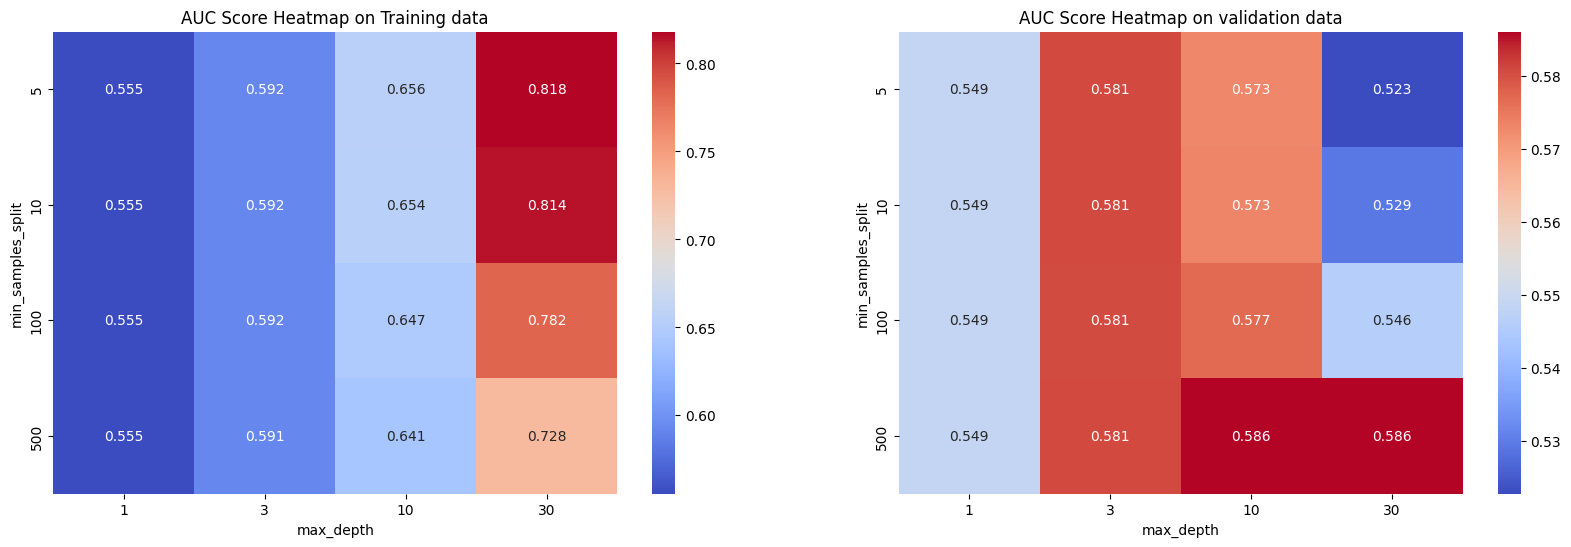

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap of training scores
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(train_scores, annot=True, fmt='.3g', cmap='coolwarm', ax=ax[0])
# set the title and labels
ax[0].set_title("AUC Score Heatmap on Training data")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("min_samples_split")

# Create the heatmap of validation scores
sns.heatmap(val_scores, annot=True, fmt='.3g', cmap='coolwarm', ax=ax[1])
# set the title and labels
ax[1].set_title("AUC Score Heatmap on validation data")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_samples_split")

# show the plot
plt.show()


From the train_scores and val_scores heatmaps, we can see that the AUC score increases with increasing max_depth and decreasing min_samples_split. 

I think there is a trade-off between the two hyperparameters because a high max_depth and low min_samples_split is overfitting on train data. it shows, high AUC score on the training set but a lower score on the validation set.

i think the best combination of hyperparameters is max_depth=10 and min_samples_split=5 , as it results in a relatively high AUC score on both the training set (approximately 0.66) and the validation set (approximately 0.57).

# 10. Find the best parameters and fit the model. Plot ROC-AUC curve(using predict proba method)

Accuracy: 0.829939393939394
ROC AUC: 0.6038436492600573
Training Accuracy: 0.8463800400980174
Training ROC AUC: 0.6493841136562349


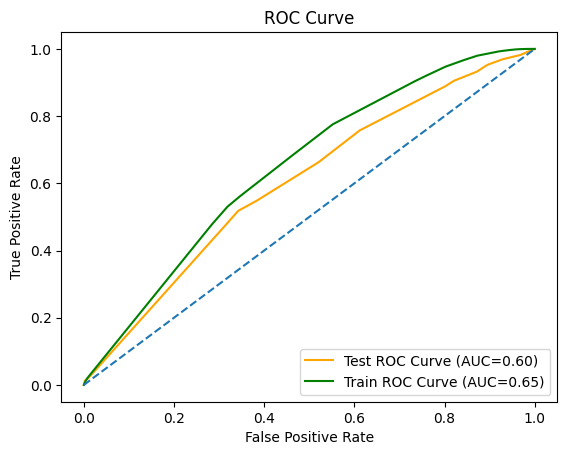

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Initialize decision tree model
best_dt_clf_1_set_1 = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)

# Train decision tree model on training data with Best hyperparameters
best_dt_clf_1_set_1.fit(X_train_set1, y_train)

# Evaluate the classifier on the testing set
y_pred_proba_1_set_1 = best_dt_clf_1_set_1.predict_proba(X_test_set1)[:,1]
accuracy_1_set_1 = accuracy_score(y_test, y_pred_proba_1_set_1.round())
roc_auc_1_set_1 = roc_auc_score(y_test, y_pred_proba_1_set_1)
print("Accuracy:", accuracy_1_set_1)
print("ROC AUC:", roc_auc_1_set_1)

# Evaluate the classifier on the training set
y_train_pred_proba_1_set_1 = best_dt_clf_1_set_1.predict_proba(X_train_set1)[:,1]
accuracy_train_1_set_1 = accuracy_score(y_train, y_train_pred_proba_1_set_1.round())
roc_auc_train_1_set_1 = roc_auc_score(y_train, y_train_pred_proba_1_set_1)
print("Training Accuracy:", accuracy_train_1_set_1)
print("Training ROC AUC:", roc_auc_train_1_set_1)

# Plot the ROC curve for both the training and testing set using the roc_curve function 
fpr_1_set_1, tpr_1_set_1, _ = roc_curve(y_test, y_pred_proba_1_set_1)
fpr_train_1_set_1, tpr_train_1_set_1, _ = roc_curve(y_train, y_train_pred_proba_1_set_1)

plt.plot(fpr_1_set_1, tpr_1_set_1, color='orange', linestyle='-', label='Test ROC Curve (AUC={:.2f})'.format(roc_auc_1_set_1))
plt.plot(fpr_train_1_set_1, tpr_train_1_set_1, color='green', linestyle='-', label='Train ROC Curve (AUC={:.2f})'.format(roc_auc_train_1_set_1))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Here, i used best hyperparameter given by grid search i.e.: best_params = grid_search.best_params_ which is :

 - max_depth=best_params['max_depth'], 
 - min_samples_split=best_params['min_samples_split']

Found that, the accuracy of the model on the training set is 0.8463800400980174 and the ROC AUC score is 0.6493841136562349.

While the accuracy was 0.829939393939394 and ROC AUC is 0.6038436492600573 on test set  

This means that the model is performing slightly better on the training set than on the test set. 

Considering this as an indication of overfitting, where the model is fitting too closely to the training data and not generalizing well to new data, I am performing it on my described best hyperparameters i.e. max_depth=10, min_samples_split=5

Accuracy: 0.8278787878787879
ROC AUC: 0.5870485422107155
Training Accuracy: 0.8633548674537759
Training ROC AUC: 0.667007920667889


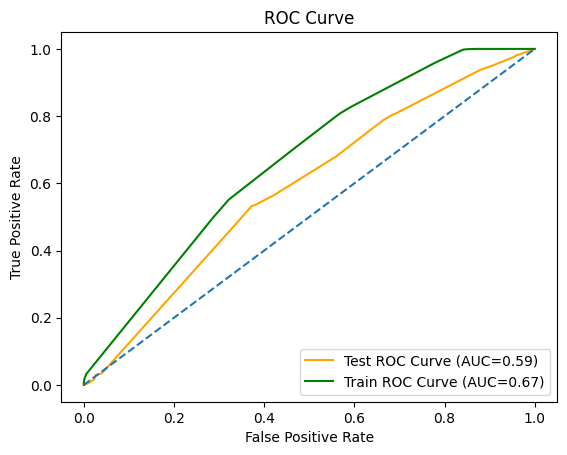

In [19]:
# Initialize decision tree model
best_dt_clf_2_set_1 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

# Train decision tree model on training data with Best hyperparameters
best_dt_clf_2_set_1.fit(X_train_set1, y_train)

# Evaluate the classifier on the testing set
y_pred_proba_2_set_1 = best_dt_clf_2_set_1.predict_proba(X_test_set1)[:,1]
accuracy_2_set_1 = accuracy_score(y_test, y_pred_proba_2_set_1.round())
roc_auc_2_set_1 = roc_auc_score(y_test, y_pred_proba_2_set_1)
print("Accuracy:", accuracy_2_set_1)
print("ROC AUC:", roc_auc_2_set_1)

# Evaluate the classifier on the training set
y_train_pred_proba_2_set_1 = best_dt_clf_2_set_1.predict_proba(X_train_set1)[:,1]
accuracy_train_2_set_1 = accuracy_score(y_train, y_train_pred_proba_2_set_1.round())
roc_auc_train_2_set_1 = roc_auc_score(y_train, y_train_pred_proba_2_set_1)
print("Training Accuracy:", accuracy_train_2_set_1)
print("Training ROC AUC:", roc_auc_train_2_set_1)

# Plot the ROC curve using the roc_curve function 
fpr_2_set_1, tpr_2_set_1, _ = roc_curve(y_test, y_pred_proba_2_set_1)
fpr_train_2_set_1, tpr_train_2_set_1, _ = roc_curve(y_train, y_train_pred_proba_2_set_1)

plt.plot(fpr_2_set_1, tpr_2_set_1, color='orange', linestyle='-', label='Test ROC Curve (AUC={:.2f})'.format(roc_auc_2_set_1))
plt.plot(fpr_train_2_set_1, tpr_train_2_set_1, color='green', linestyle='-', label='Train ROC Curve (AUC={:.2f})'.format(roc_auc_train_2_set_1))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Similar to the previous set of data, the accuracy of the model on the test set is 0.8278787878787879 and The ROC AUC score of 0.5870485422107155

Also, The accuracy of the model on the training set is 0.8633548674537759 and the ROC AUC score is 0.667007920667889. 

Although both sets of hyperparameters have similar accuracy scores on the test set, the previous one has a higher ROC AUC score, meaning that its better at classifying between the positive and negative classes.

# 11. Plot confusion matrix based on best threshold value

Confusion Matrix:
[[1737  905]
 [6676 7182]]
Accuracy: 0.5405454545454546
Precision: 0.888091999505379
Recall: 0.51825660268437
F1 Score: 0.6545454545454544


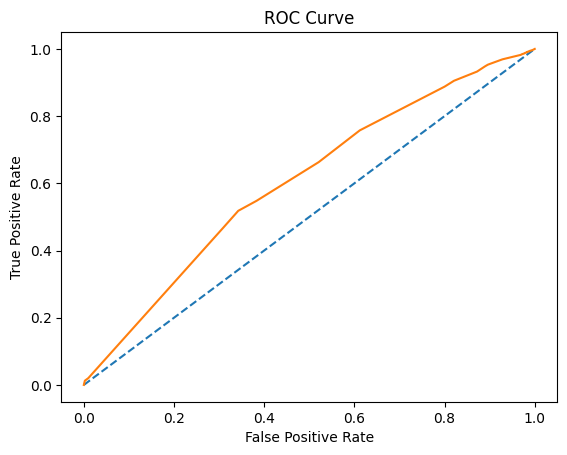

In [20]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize decision tree model
best_dt_clf = DecisionTreeClassifier(max_depth=best_params['max_depth'], 
                                     min_samples_split=best_params['min_samples_split'], 
                                     random_state=42)

# Train decision tree model on training data with Best hyperparameters
best_dt_clf.fit(X_train_set1, y_train)

# Evaluate the classifier on the testing set
y_pred_proba = best_dt_clf.predict_proba(X_test_set1)[:,1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Find the threshold value that gives the highest sum of sensitivity and specificity
best_idx = np.argmax(tpr + (1 - fpr))
best_threshold = thresholds[best_idx]

# Apply the best threshold to the predicted probabilities to get the predicted class labels
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Calculate the confusion matrix based on the predicted class labels and the true class labels
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

# Calculate the accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

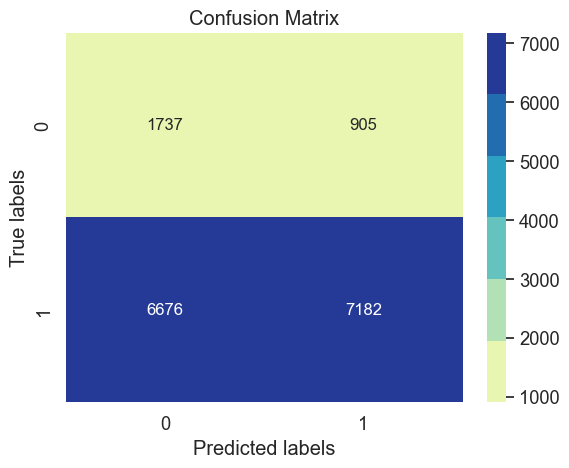

In [21]:
import seaborn as sns

# Set font scale and annotation size
sns.set(font_scale=1.2)
annot_kws = {"size": 12}

# Set colormap with bright colors
cmap = sns.color_palette("YlGnBu")

# Plot confusion matrix
sns.heatmap(cm, annot=True, annot_kws=annot_kws, fmt='g', cmap=cmap)

# Set axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# 12. Find all the false positive data points and plot wordcloud of essay text and pdf of teacher_number_of_previously_posted_projects.

In [22]:
# Find the false positive data points
false_positive_idx = np.where((y_pred == 1) & (y_test == 0))[0]
false_positive_samples = X_test_set1[false_positive_idx]

print("Number of false positive data points:", len(false_positive_idx))
print("False positive samples:", false_positive_samples)

Number of false positive data points: 905
False positive samples:   (0, 155)	0.18021254423588057
  (0, 158)	0.09507133372540615
  (0, 248)	0.04910880838509185
  (0, 254)	0.05399203259064037
  (0, 257)	0.10660011843223903
  (0, 381)	0.049249978234629864
  (0, 448)	0.12359738663793386
  (0, 455)	0.09611982781419325
  (0, 512)	0.16953928196518864
  (0, 618)	0.12445558306874328
  (0, 640)	0.11236332847736777
  (0, 681)	0.02418419402096131
  (0, 722)	0.06693937085485835
  (0, 777)	0.030580105167763057
  (0, 781)	0.09172104627633125
  (0, 782)	0.1039887912456744
  (0, 828)	0.08347126496572152
  (0, 948)	0.04269717229478955
  (0, 951)	0.1069711344231693
  (0, 954)	0.06125837564050623
  (0, 964)	0.10228042128429503
  (0, 987)	0.06031294456173851
  (0, 1081)	0.16440267984600596
  (0, 1082)	0.08360351780890905
  (0, 1199)	0.04497141217933305
  :	:
  (904, 4377)	0.10931412664283209
  (904, 4522)	0.03342384509911806
  (904, 4537)	0.10907576697059533
  (904, 4648)	0.0640137040551174
  (904, 4662)	0

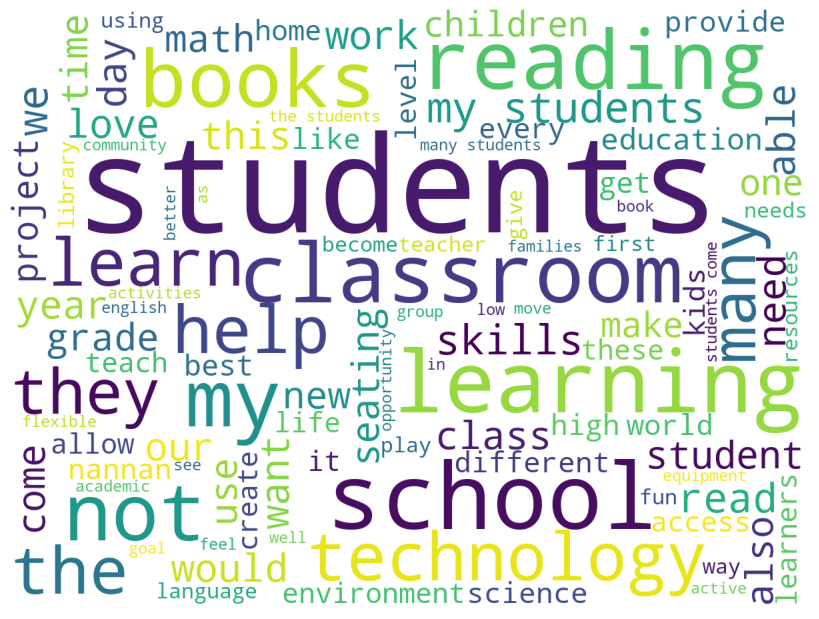

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert false positive samples to dense numpy array
false_positive_samples = false_positive_samples.toarray()

# Get list of words from X_train_essay_tfidf
essay_words = list(vectorizer_essay.get_feature_names_out())

# Create a dictionary of words and their frequency counts
word_counts = {}
for i in range(false_positive_samples.shape[0]):
    for j in range(false_positive_samples.shape[1]):
        if false_positive_samples[i][j] > 0:
            if j < len(essay_words):
                word_counts[essay_words[j]] = word_counts.get(essay_words[j], 0) + false_positive_samples[i][j]

# Create WordCloud object
wordcloud = WordCloud(width=1200, height=900, background_color='white', max_words=100).generate_from_frequencies(word_counts)

# Plot WordCloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


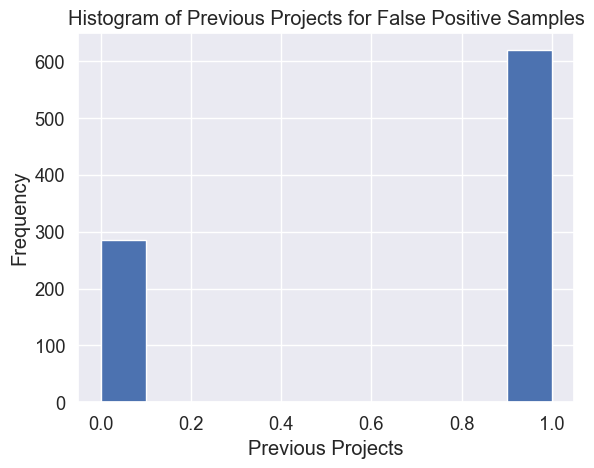

In [24]:
# Get values of X_train_prev_projects_normalized corresponding to false positive samples
false_positive_prev_projects = X_train_prev_projects_normalized[false_positive_idx]

# Create histogram
plt.hist(false_positive_prev_projects, bins=10, range=(0, 1))
plt.xlabel('Previous Projects')
plt.ylabel('Frequency')
plt.title('Histogram of Previous Projects for False Positive Samples')
plt.show()

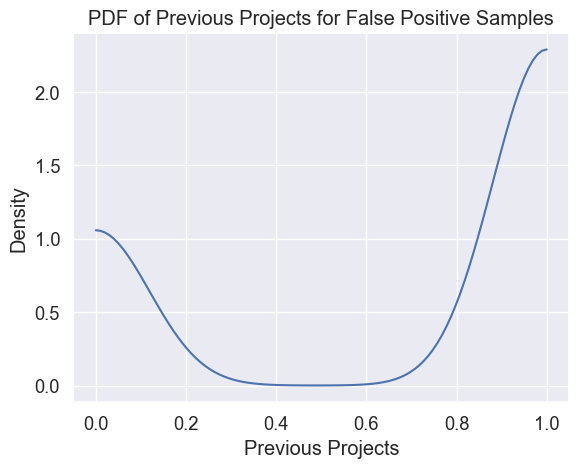

In [25]:
import numpy as np
from scipy.stats import gaussian_kde

# assuming X_train_prev_projects_normalized is a numpy array
false_positive_prev_projects = X_train_prev_projects_normalized[false_positive_idx]
false_positive_prev_projects_T = np.transpose(false_positive_prev_projects)

# create a kernel density estimate for the false positive prev projects
kde = gaussian_kde(false_positive_prev_projects_T)

# evaluate the density estimate on a grid
x = np.linspace(0, 1, num=100)
density = kde(x)

# plot the density estimate
plt.plot(x, density)
plt.xlabel('Previous Projects')
plt.ylabel('Density')
plt.title('PDF of Previous Projects for False Positive Samples')
plt.show()


# Implementing the same for set 2 now: 

### Set 2: categorical, numerical features + preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)


In [26]:
# Define parameter grid
param_grid = {'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]}

# Create a decision tree classifier object
dt_clf = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV object with cross-validation
grid_search_set2 = GridSearchCV(dt_clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True)

# Fit the grid search object to the data
grid_search_set2.fit(X_train_set2, y_train)

# Print the best hyperparameters and corresponding AUC score
best_params_set2 = grid_search_set2.best_params_
print("Best hyperparameters set 2:", best_params_set2)
print("Best AUC score set 2:", grid_search_set2.best_score_)

Best hyperparameters set 2: {'max_depth': 3, 'min_samples_split': 5}
Best AUC score set 2: 0.5965050929119797


In [27]:
results_df_set2 = pd.DataFrame(grid_search_set2.cv_results_)
results_df_set2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.691955,0.036465,0.007031,0.000884,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.546811,0.564976,0.533226,...,0.552211,0.011227,10,0.565648,0.558891,0.567503,0.561574,0.559697,0.562663,0.003363
1,0.674832,0.015489,0.006558,0.001082,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.546811,0.564976,0.533226,...,0.552211,0.011227,10,0.565648,0.558891,0.567503,0.561574,0.559697,0.562663,0.003363
2,0.659438,0.003949,0.006978,0.001300,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.546811,0.564976,0.533226,...,0.552211,0.011227,10,0.565648,0.558891,0.567503,0.561574,0.559697,0.562663,0.003363
3,0.654614,0.009359,0.006278,0.001186,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.546811,0.564976,0.533226,...,0.552211,0.011227,10,0.565648,0.558891,0.567503,0.561574,0.559697,0.562663,0.003363
4,1.765457,0.011270,0.008218,0.000268,3,5,"{'max_depth': 3, 'min_samples_split': 5}",0.585118,0.605901,0.598581,...,0.596505,0.006687,1,0.625376,0.617449,0.626579,0.623857,0.617319,0.622116,0.003959
5,1.761901,0.013371,0.007650,0.000481,3,10,"{'max_depth': 3, 'min_samples_split': 10}",0.585118,0.605901,0.598581,...,0.596505,0.006687,1,0.625376,0.617449,0.626579,0.623857,0.617319,0.622116,0.003959
6,1.835413,0.144960,0.007893,0.000250,3,100,"{'max_depth': 3, 'min_samples_split': 100}",0.585118,0.605901,0.598581,...,0.596505,0.006687,1,0.625376,0.617449,0.626579,0.623857,0.617319,0.622116,0.003959
7,1.788507,0.065183,0.008936,0.000195,3,500,"{'max_depth': 3, 'min_samples_split': 500}",0.585118,0.605901,0.598581,...,0.596505,0.006687,1,0.625376,0.617449,0.626579,0.623857,0.617319,0.622116,0.003959
8,7.465123,0.284365,0.008267,0.000724,10,5,"{'max_depth': 10, 'min_samples_split': 5}",0.555196,0.563090,0.575490,...,0.568965,0.008579,9,0.795022,0.799850,0.780497,0.759246,0.783602,0.783643,0.014123
9,7.398818,0.265648,0.008391,0.000795,10,10,"{'max_depth': 10, 'min_samples_split': 10}",0.560859,0.570486,0.576661,...,0.570039,0.005263,8,0.790885,0.797521,0.776477,0.757501,0.780223,0.780521,0.013732


In [28]:
# Create the heatmap of training scores
train_scores_set2 = results_df_set2.pivot(index='param_min_samples_split', columns='param_max_depth', values='mean_train_score')

# param_min_samples_split column becomes the new index of train_scores 
# the param_max_depth column becomes the new column headers. 
# The values of the mean_test_score column are then used to fill the cells of the new dataframe. 
# here, 'mean_train_score' corresponds to the mean AUC score across all cross-validation folds because the scoring parameter of GridSearchCV was 'roc_auc'

print(train_scores_set2)

param_max_depth                 1         3        10        30
param_min_samples_split                                        
5                        0.562663  0.622116  0.783643  0.987368
10                       0.562663  0.622116  0.780521  0.982113
100                      0.562663  0.622116  0.745490  0.913161
500                      0.562663  0.622116  0.711172  0.785511


In [29]:
# Create the heatmap of validation scores
val_scores_set2 = results_df.pivot(index='param_min_samples_split', columns='param_max_depth', values='mean_test_score')
print(val_scores_set2)

param_max_depth                 1         3        10        30
param_min_samples_split                                        
5                        0.548925  0.580668  0.572829  0.522757
10                       0.548925  0.580668  0.573328  0.529339
100                      0.548925  0.580562  0.576962  0.546135
500                      0.548925  0.580674  0.586065  0.585896


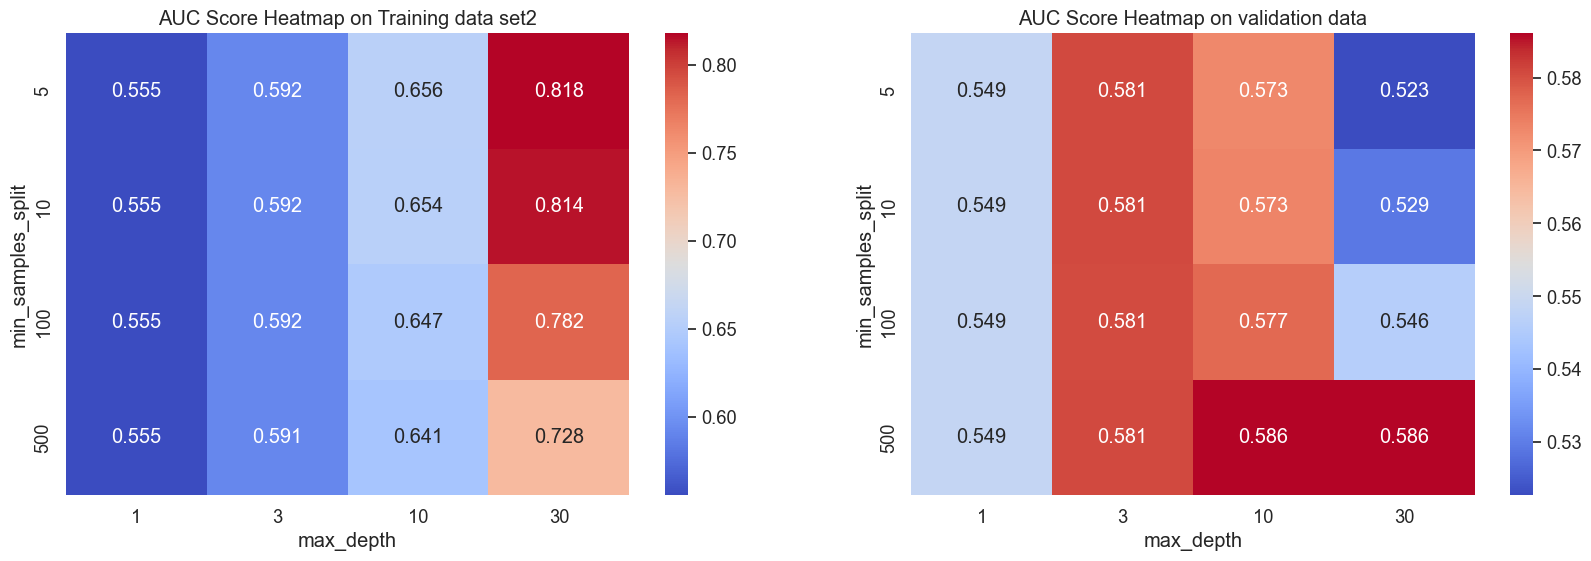

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap of training scores
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(train_scores, annot=True, fmt='.3g', cmap='coolwarm', ax=ax[0])
# set the title and labels
ax[0].set_title("AUC Score Heatmap on Training data set2")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("min_samples_split")

# Create the heatmap of validation scores
sns.heatmap(val_scores_set2, annot=True, fmt='.3g', cmap='coolwarm', ax=ax[1])
# set the title and labels
ax[1].set_title("AUC Score Heatmap on validation data")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_samples_split")

# show the plot
plt.show()


Accuracy: 0.830060606060606
ROC AUC: 0.6019407237396196
Training Accuracy: 0.8458899532189798
Training ROC AUC: 0.7121133315871218


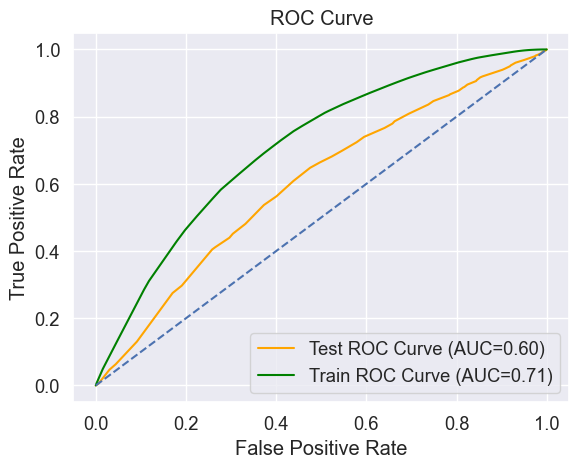

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Initialize decision tree model
best_dt_clf_set2 = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)

# Train decision tree model on training data with Best hyperparameters
best_dt_clf_set2.fit(X_train_set2, y_train)

# Evaluate the classifier on the testing set
y_pred_proba_set2 = best_dt_clf_set2.predict_proba(X_test_set2)[:,1]
accuracy_set2 = accuracy_score(y_test, y_pred_proba_set2.round())
roc_auc_set2 = roc_auc_score(y_test, y_pred_proba_set2)
print("Accuracy:", accuracy_set2)
print("ROC AUC:", roc_auc_set2)

# Evaluate the classifier on the training set
y_train_pred_proba_set2 = best_dt_clf_set2.predict_proba(X_train_set2)[:,1]
accuracy_train_set2 = accuracy_score(y_train, y_train_pred_proba_set2.round())
roc_auc_train_set2 = roc_auc_score(y_train, y_train_pred_proba_set2)
print("Training Accuracy:", accuracy_train_set2)
print("Training ROC AUC:", roc_auc_train_set2)

# Plot the ROC curve for both the training and testing set using the roc_curve function 
fpr_set2, tpr_set2, _ = roc_curve(y_test, y_pred_proba_set2)
fpr_train_set2, tpr_train_set2, _ = roc_curve(y_train, y_train_pred_proba_set2)

plt.plot(fpr_set2, tpr_set2, color='orange', linestyle='-', label='Test ROC Curve (AUC={:.2f})'.format(roc_auc_set2))
plt.plot(fpr_train_set2, tpr_train_set2, color='green', linestyle='-', label='Train ROC Curve (AUC={:.2f})'.format(roc_auc_train_set2))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix:
[[ 1086  1556]
 [ 3659 10199]]
Accuracy: 0.683939393939394
Precision: 0.8676307954062101
Recall: 0.7359647856833598
F1 Score: 0.7963924569554522


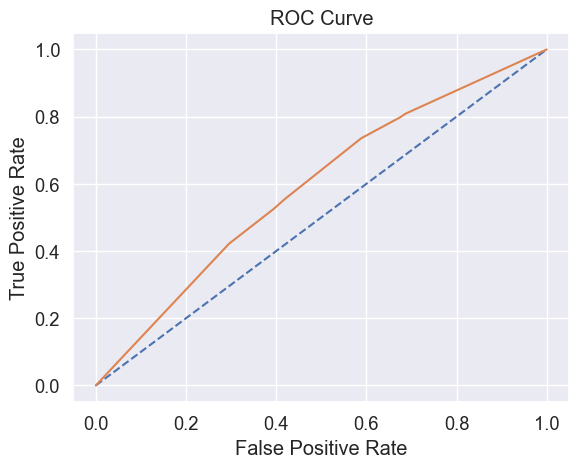

In [32]:
# Initialize decision tree model
best_dt_clf_set2 = DecisionTreeClassifier(max_depth=best_params_set2['max_depth'], 
                                     min_samples_split=best_params_set2['min_samples_split'], 
                                     random_state=42)

# Train decision tree model on training data with Best hyperparameters
best_dt_clf_set2.fit(X_train_set2, y_train)

# Evaluate the classifier on the testing set
y_pred_proba_set2 = best_dt_clf_set2.predict_proba(X_test_set2)[:,1]

# Calculate the ROC curve
fpr_set2, tpr_set2, thresholds_set2 = roc_curve(y_test, y_pred_proba_set2)

# Find the threshold value that gives the highest sum of sensitivity and specificity
best_idx_set2 = np.argmax(tpr_set2 + (1 - fpr_set2))
best_threshold_set2 = thresholds_set2[best_idx_set2]

# Apply the best threshold to the predicted probabilities to get the predicted class labels
y_pred_set2 = (y_pred_proba_set2 >= best_threshold_set2).astype(int)

# Calculate the confusion matrix based on the predicted class labels and the true class labels
cm_set2 = confusion_matrix(y_test, y_pred_set2)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm_set2)

# Calculate the accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_set2)
precision = precision_score(y_test, y_pred_set2)
recall = recall_score(y_test, y_pred_set2)
f1 = f1_score(y_test, y_pred_set2)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_set2, tpr_set2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

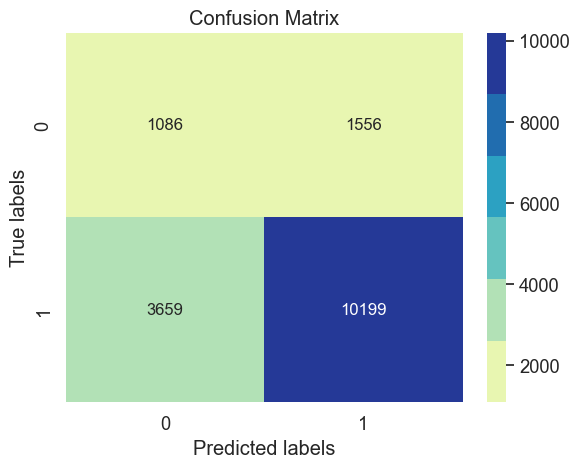

In [33]:
import seaborn as sns

# Set font scale and annotation size
sns.set(font_scale=1.2)
annot_kws = {"size": 12}

# Set colormap with bright colors
cmap = sns.color_palette("YlGnBu")

# Plot confusion matrix
sns.heatmap(cm_set2, annot=True, annot_kws=annot_kws, fmt='g', cmap=cmap)

# Set axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# Find the false positive data points
false_positive_idx_set2 = np.where((y_pred == 1) & (y_test == 0))[0]
false_positive_samples_set2 = X_test_set1[false_positive_idx_set2]

print("Number of false positive data points:", len(false_positive_idx_set2))
print("False positive samples:", false_positive_samples_set2)

Number of false positive data points: 905
False positive samples:   (0, 155)	0.18021254423588057
  (0, 158)	0.09507133372540615
  (0, 248)	0.04910880838509185
  (0, 254)	0.05399203259064037
  (0, 257)	0.10660011843223903
  (0, 381)	0.049249978234629864
  (0, 448)	0.12359738663793386
  (0, 455)	0.09611982781419325
  (0, 512)	0.16953928196518864
  (0, 618)	0.12445558306874328
  (0, 640)	0.11236332847736777
  (0, 681)	0.02418419402096131
  (0, 722)	0.06693937085485835
  (0, 777)	0.030580105167763057
  (0, 781)	0.09172104627633125
  (0, 782)	0.1039887912456744
  (0, 828)	0.08347126496572152
  (0, 948)	0.04269717229478955
  (0, 951)	0.1069711344231693
  (0, 954)	0.06125837564050623
  (0, 964)	0.10228042128429503
  (0, 987)	0.06031294456173851
  (0, 1081)	0.16440267984600596
  (0, 1082)	0.08360351780890905
  (0, 1199)	0.04497141217933305
  :	:
  (904, 4377)	0.10931412664283209
  (904, 4522)	0.03342384509911806
  (904, 4537)	0.10907576697059533
  (904, 4648)	0.0640137040551174
  (904, 4662)	0

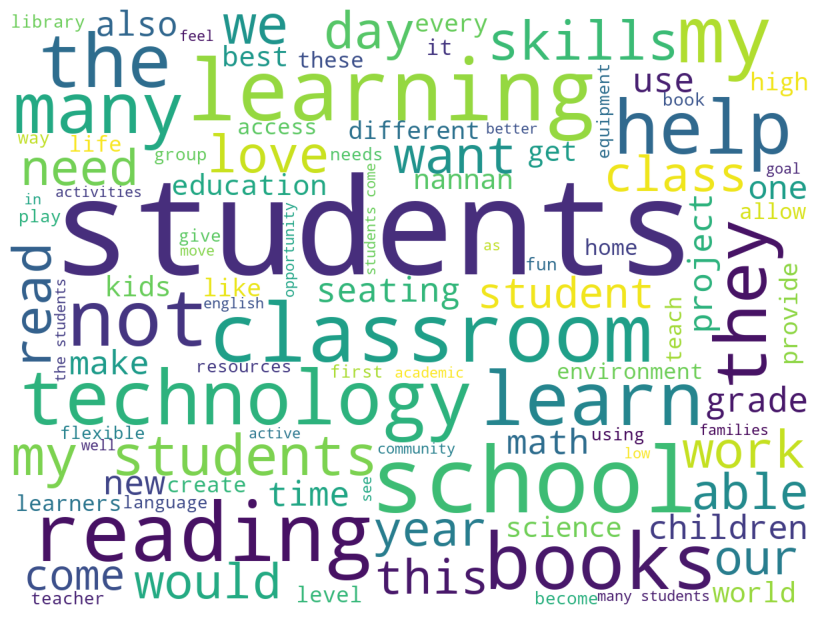

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert false positive samples to dense numpy array
false_positive_samples_set2 = false_positive_samples_set2.toarray()

# Get list of words from X_train_essay_tfidf
essay_words = list(vectorizer_essay.get_feature_names_out())

# Create a dictionary of words and their frequency counts
word_counts_set2 = {}
for i in range(false_positive_samples_set2.shape[0]):
    for j in range(false_positive_samples_set2.shape[1]):
        if false_positive_samples_set2[i][j] > 0:
            if j < len(essay_words):
                word_counts_set2[essay_words[j]] = word_counts_set2.get(essay_words[j], 0) + false_positive_samples_set2[i][j]

# Create WordCloud object
wordcloud = WordCloud(width=1200, height=900, background_color='white', max_words=100).generate_from_frequencies(word_counts_set2)

# Plot WordCloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


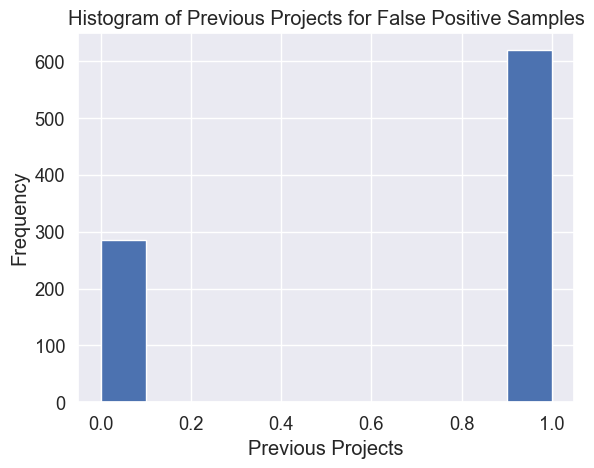

In [36]:
# Get values of X_train_prev_projects_normalized corresponding to false positive samples
false_positive_prev_projects_set2 = X_train_prev_projects_normalized[false_positive_idx_set2]

# Create histogram
plt.hist(false_positive_prev_projects_set2, bins=10, range=(0, 1))
plt.xlabel('Previous Projects')
plt.ylabel('Frequency')
plt.title('Histogram of Previous Projects for False Positive Samples')
plt.show()

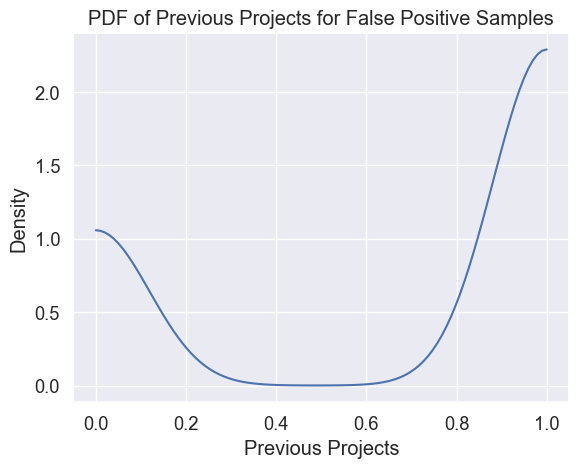

In [37]:
import numpy as np
from scipy.stats import gaussian_kde

# assuming X_train_prev_projects_normalized is a numpy array
false_positive_prev_projects_set2_T = np.transpose(false_positive_prev_projects_set2)

# create a kernel density estimate for the false positive prev projects
kde = gaussian_kde(false_positive_prev_projects_set2_T)

# evaluate the density estimate on a grid
x = np.linspace(0, 1, num=100)
density = kde(x)

# plot the density estimate
plt.plot(x, density)
plt.xlabel('Previous Projects')
plt.ylabel('Density')
plt.title('PDF of Previous Projects for False Positive Samples')
plt.show()

# Task - 2

# 1. select all non zero features

In [38]:

# Feature names for essay
essay_feature_names = vectorizer_essay.get_feature_names_out()
print( "shape of Feature names for essay: ", essay_feature_names.shape)

# Feature names for category
category_feature_names = vectorizer_categories.get_feature_names_out()
print("shape of Feature names for category: ", category_feature_names.shape)

# Feature names for subcategory
subcategory_feature_names = vectorizer_subcategories.get_feature_names_out()
print("shape of Feature names for subcategory: ", subcategory_feature_names.shape)

# Feature names for school state
school_state_feature_names = features_school_state
print("shape of Feature names for school state", school_state_feature_names.shape)

# Feature names for teacher prefix
teacher_prefix_feature_names = features_teacher_prefix
print("shape of Feature names for teacher prefix: ", teacher_prefix_feature_names.shape)

# Feature names for project grade category
project_grade_category_feature_names = features_project_grade_category
print("shape of Feature names for project grade category: ", project_grade_category_feature_names.shape)

result_features = np.concatenate((essay_feature_names, category_feature_names, subcategory_feature_names, school_state_feature_names, teacher_prefix_feature_names, project_grade_category_feature_names))

print("shape of final feature names: ", result_features.shape)

shape of Feature names for essay:  (5000,)
shape of Feature names for category:  (9,)
shape of Feature names for subcategory:  (30,)
shape of Feature names for school state (51,)
shape of Feature names for teacher prefix:  (5,)
shape of Feature names for project grade category:  (4,)
shape of final feature names:  (5099,)


In [39]:
# Extract the non-zero feature importances
non_zero_feat_importances = best_dt_clf.feature_importances_[best_dt_clf.feature_importances_ != 0]
non_zero_feat_indices = [i for i in range(len(best_dt_clf.feature_importances_)) if best_dt_clf.feature_importances_[i] != 0]
len(non_zero_feat_importances)

44

In [40]:
print(non_zero_feat_importances)
print(non_zero_feat_indices)

[0.01603878 0.01296834 0.01088876 0.01742248 0.01863544 0.01083017
 0.01124982 0.01567793 0.01571206 0.01561608 0.01234201 0.01469446
 0.0161057  0.01423733 0.01197654 0.01333993 0.0413711  0.01662527
 0.0171809  0.0156593  0.0160974  0.01819769 0.12956947 0.01964769
 0.12813259 0.01574011 0.02366776 0.0139298  0.02474858 0.01264455
 0.01637808 0.01527493 0.01662131 0.01471281 0.01782552 0.0127697
 0.08515007 0.0130881  0.01293547 0.01228601 0.01572733 0.01077205
 0.01859873 0.01691189]
[21, 113, 158, 400, 486, 858, 1059, 1242, 1504, 1690, 1787, 1805, 1831, 2003, 2042, 2076, 2151, 2233, 2244, 2315, 2342, 2565, 2604, 2608, 2825, 2852, 2898, 3047, 3059, 3151, 3199, 3325, 3379, 3576, 3820, 3920, 4294, 4343, 4406, 4453, 4508, 4541, 4662, 4872]


In [41]:
# Access the elements in `result_features` corresponding to the indices in `non_zero_feat_indices`
# and store them in a new array called `non_zero_features`

non_zero_features = result_features[non_zero_feat_indices[:-1]] 
# slicing last element of non_zero_feat_indices because the last element is 5099 
# i.e. index 5099 which is not possible for result_features because it has shape: (5099,) that means the last index of result_features is 5098
 
print(non_zero_features)

['2016' 'absolutely' 'activities students' 'based' 'books' 'comprehend'
 'despite many' 'educators' 'feel safe' 'garden' 'greatly appreciated'
 'grow' 'hard' 'importance' 'incorporate' 'inquisitive' 'items' 'later'
 'learn' 'learning experiences' 'learning styles' 'manipulatives'
 'materials' 'materials help' 'nannan' 'need materials' 'next generation'
 'our school' 'outside box' 'physical education' 'population' 'proven'
 'reach' 'scholars' 'smart' 'standards' 'supplies' 'teach' 'the'
 'these children' 'things simple provide' 'though' 'use']


along with the above non_zero_features there is one more non zero feature which has index of 5099 and it is a numerical feature so i am using it in the next step where i will update dataset which contains all rows and only non zero features

# 3. Update your dataset i.e. X_train,X_test and X_cv so that it contains all rows and only non zero features

In [42]:
# Slice the feature matrices to include only the non-zero feature columns
X_train_set1_new = X_train_set1[:, non_zero_feat_indices]
X_cv_set1_new = X_cv_set1[:, non_zero_feat_indices]
X_test_set1_new = X_test_set1[:, non_zero_feat_indices]

# Check the new shapes of the feature matrices
print(X_train_set1_new.shape, y_train.shape)
print(X_cv_set1_new.shape, y_cv.shape)
print(X_test_set1_new.shape, y_test.shape)

(22445, 44) (22445,)
(11055, 44) (11055,)
(16500, 44) (16500,)


# 4. perform hyperparameter tuning and plot either heatmap or 3d plot.

In [43]:
# Define parameter grid
param_grid = {'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]}

# Create a decision tree classifier object
dt_clf_t2 = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV object with cross-validation
grid_search_t2 = GridSearchCV(dt_clf_t2, param_grid, cv=5, scoring='roc_auc', return_train_score=True)

# Fit the grid search object to the data
grid_search_t2.fit(X_train_set1, y_train)

# Print the best hyperparameters and corresponding AUC score
best_params_t2 = grid_search_t2.best_params_
print("Best hyperparameters:", best_params_t2)
print("Best AUC score:", grid_search_t2.best_score_)

Best hyperparameters: {'max_depth': 10, 'min_samples_split': 500}
Best AUC score: 0.5860646417991389


In [44]:
results_df_t2 = pd.DataFrame(grid_search.cv_results_)
results_df_t2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.612793,0.027661,0.012513,0.006257,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
1,0.623684,0.034752,0.014292,0.002850,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
2,0.410538,0.152746,0.006767,0.004125,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
3,0.275028,0.013903,0.004612,0.000782,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.554333,0.561843,0.557878,...,0.548925,0.019185,10,0.564309,0.562530,0.563521,0.562992,0.524008,0.555472,0.015743
4,0.754087,0.009958,0.005069,0.000818,3,5,"{'max_depth': 3, 'min_samples_split': 5}",0.575802,0.578841,0.583646,...,0.580668,0.003246,4,0.599836,0.591271,0.593395,0.589528,0.584550,0.591716,0.005002
5,0.723350,0.026846,0.005220,0.001160,3,10,"{'max_depth': 3, 'min_samples_split': 10}",0.575802,0.578841,0.583646,...,0.580668,0.003246,4,0.599836,0.591271,0.593395,0.589528,0.584550,0.591716,0.005002
6,0.703537,0.015404,0.005359,0.000482,3,100,"{'max_depth': 3, 'min_samples_split': 100}",0.575802,0.578841,0.583646,...,0.580562,0.003265,6,0.599836,0.591271,0.593395,0.589528,0.583960,0.591598,0.005173
7,0.682705,0.010907,0.004401,0.001020,3,500,"{'max_depth': 3, 'min_samples_split': 500}",0.576515,0.578822,0.583602,...,0.580674,0.003034,3,0.599770,0.590971,0.593307,0.589197,0.583960,0.591441,0.005178
8,2.885443,0.313049,0.005037,0.000044,10,5,"{'max_depth': 10, 'min_samples_split': 5}",0.554691,0.575164,0.587736,...,0.572829,0.012440,9,0.663439,0.662416,0.652509,0.654913,0.646455,0.655946,0.006340
9,2.711239,0.089688,0.005137,0.000273,10,10,"{'max_depth': 10, 'min_samples_split': 10}",0.549574,0.583987,0.592798,...,0.573328,0.017480,8,0.662849,0.661194,0.650408,0.653181,0.644647,0.654456,0.006783


In [45]:
# Create the heatmap of training scores
train_scores_t2 = results_df_t2.pivot(index='param_min_samples_split', columns='param_max_depth', values='mean_train_score')

# param_min_samples_split column becomes the new index of train_scores 
# the param_max_depth column becomes the new column headers. 
# The values of the mean_test_score column are then used to fill the cells of the new dataframe. 
# here, 'mean_train_score' corresponds to the mean AUC score across all cross-validation folds because the scoring parameter of GridSearchCV was 'roc_auc'

print(train_scores_t2)

param_max_depth                 1         3        10        30
param_min_samples_split                                        
5                        0.555472  0.591716  0.655946  0.818063
10                       0.555472  0.591716  0.654456  0.814304
100                      0.555472  0.591598  0.647110  0.782164
500                      0.555472  0.591441  0.641078  0.728328


In [46]:
# Create the heatmap of validation scores
val_scores_t2 = results_df_t2.pivot(index='param_min_samples_split', columns='param_max_depth', values='mean_test_score')
print(val_scores_t2)

param_max_depth                 1         3        10        30
param_min_samples_split                                        
5                        0.548925  0.580668  0.572829  0.522757
10                       0.548925  0.580668  0.573328  0.529339
100                      0.548925  0.580562  0.576962  0.546135
500                      0.548925  0.580674  0.586065  0.585896


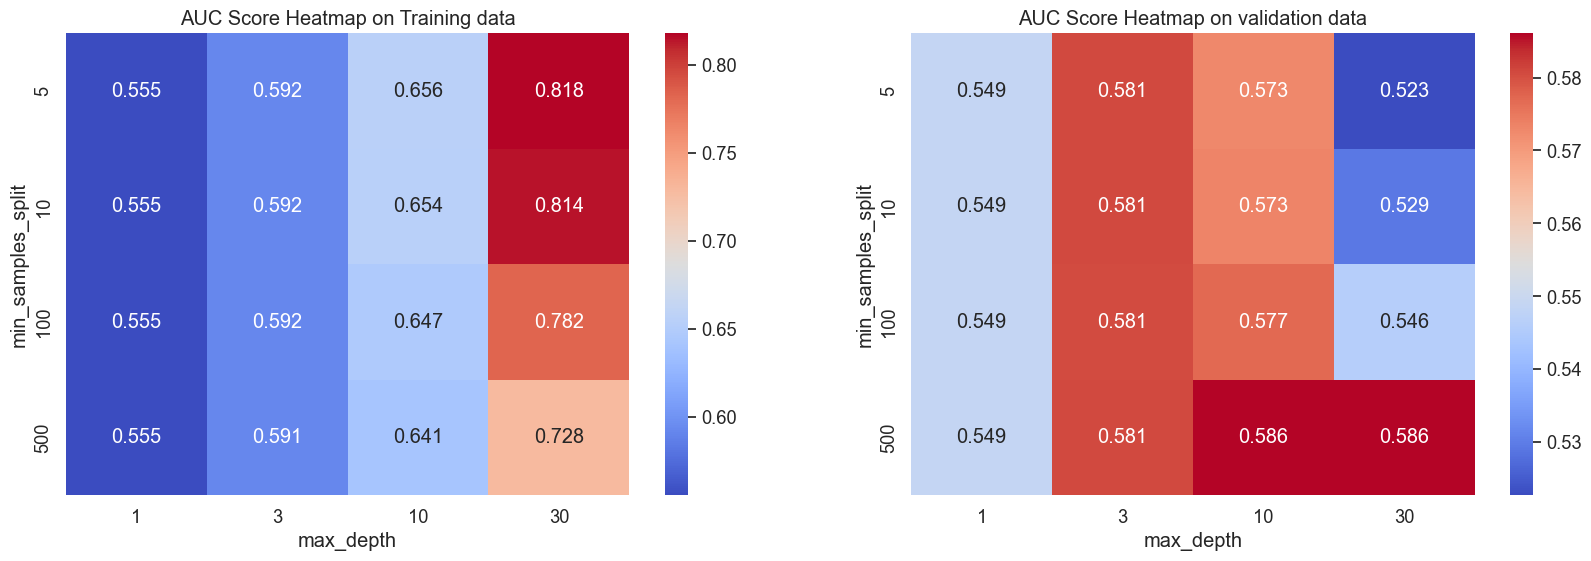

In [47]:
# Create the heatmap of training scores
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(train_scores_t2, annot=True, fmt='.3g', cmap='coolwarm', ax=ax[0])
# set the title and labels
ax[0].set_title("AUC Score Heatmap on Training data")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("min_samples_split")

# Create the heatmap of validation scores
sns.heatmap(val_scores_t2, annot=True, fmt='.3g', cmap='coolwarm', ax=ax[1])
# set the title and labels
ax[1].set_title("AUC Score Heatmap on validation data")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_samples_split")

# show the plot
plt.show()

# 5. Fit the best model. Plot ROC AUC curve and confusion matrix similar to model 1.

Accuracy: 0.829939393939394
ROC AUC: 0.6038436492600573
Training Accuracy: 0.8463800400980174
Training ROC AUC: 0.6493841136562349


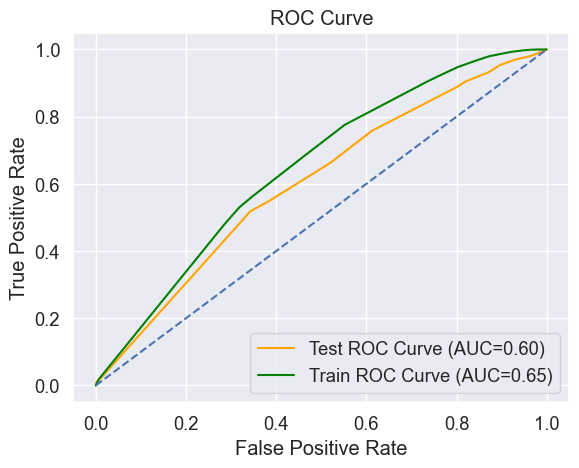

In [48]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Initialize decision tree model
best_dt_clf_t2 = DecisionTreeClassifier(max_depth=best_params_t2['max_depth'], min_samples_split=best_params_t2['min_samples_split'], random_state=42)

# Train decision tree model on training data with Best hyperparameters
best_dt_clf_t2.fit(X_train_set1_new, y_train)

# Evaluate the classifier on the testing set
y_pred_proba_t2 = best_dt_clf_t2.predict_proba(X_test_set1_new)[:,1]
accuracy_t2 = accuracy_score(y_test, y_pred_proba_t2.round())
roc_auc_t2 = roc_auc_score(y_test, y_pred_proba_t2)
print("Accuracy:", accuracy_t2)
print("ROC AUC:", roc_auc_t2)

# Evaluate the classifier on the training set
y_train_pred_proba_t2 = best_dt_clf_t2.predict_proba(X_train_set1_new)[:,1]
accuracy_train_t2 = accuracy_score(y_train, y_train_pred_proba_t2.round())
roc_auc_train_t2 = roc_auc_score(y_train, y_train_pred_proba_t2)
print("Training Accuracy:", accuracy_train_t2)
print("Training ROC AUC:", roc_auc_train_t2)

# Plot the ROC curve for both the training and testing set using the roc_curve function 
fpr_t2, tpr_t2, _ = roc_curve(y_test, y_pred_proba_t2)
fpr_train_t2, tpr_train_t2, _ = roc_curve(y_train, y_train_pred_proba_t2)

plt.plot(fpr_t2, tpr_t2, color='orange', linestyle='-', label='Test ROC Curve (AUC={:.2f})'.format(roc_auc_t2))
plt.plot(fpr_train_t2, tpr_train_t2, color='green', linestyle='-', label='Train ROC Curve (AUC={:.2f})'.format(roc_auc_train_t2))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix:
[[1737  905]
 [6676 7182]]
Accuracy: 0.5405454545454546
Precision: 0.888091999505379
Recall: 0.51825660268437
F1 Score: 0.6545454545454544


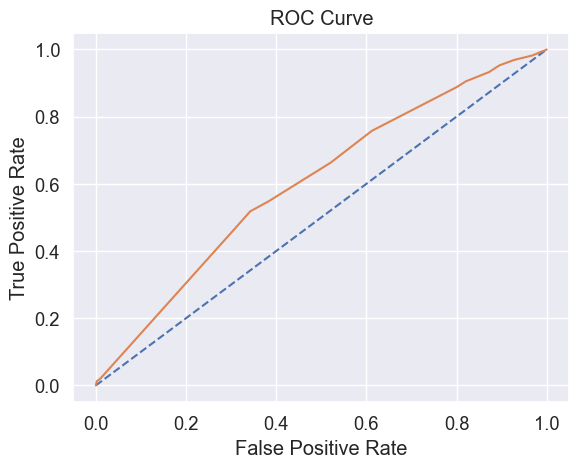

In [49]:
# Initialize decision tree model
best_dt_clf_t2 = DecisionTreeClassifier(max_depth=best_params_t2['max_depth'], 
                                     min_samples_split=best_params_t2['min_samples_split'], 
                                     random_state=42)

# Train decision tree model on training data with Best hyperparameters
best_dt_clf_t2.fit(X_train_set1_new, y_train)

# Evaluate the classifier on the testing set
y_pred_proba_t2 = best_dt_clf_t2.predict_proba(X_test_set1_new)[:,1]

# Calculate the ROC curve
fpr_t2, tpr_t2, thresholds_t2 = roc_curve(y_test, y_pred_proba_t2)

# Find the threshold value that gives the highest sum of sensitivity and specificity
best_idx_t2 = np.argmax(tpr_t2 + (1 - fpr_t2))
best_threshold_t2 = thresholds_t2[best_idx_t2]

# Apply the best threshold to the predicted probabilities to get the predicted class labels
y_pred_t2 = (y_pred_proba_t2 >= best_threshold_t2).astype(int)

# Calculate the confusion matrix based on the predicted class labels and the true class labels
cm_t2 = confusion_matrix(y_test, y_pred_t2)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm_t2)

# Calculate the accuracy, precision, recall, and F1 score
accuracy_t2 = accuracy_score(y_test, y_pred_t2)
precision_t2 = precision_score(y_test, y_pred_t2)
recall_t2 = recall_score(y_test, y_pred_t2)
f1_t2 = f1_score(y_test, y_pred_t2)

# Print the evaluation metrics
print('Accuracy:', accuracy_t2)
print('Precision:', precision_t2)
print('Recall:', recall_t2)
print('F1 Score:', f1_t2)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_t2, tpr_t2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

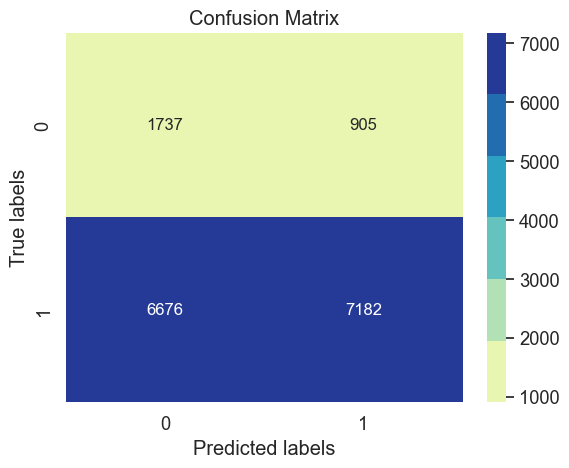

In [50]:
import seaborn as sns

# Set font scale and annotation size
sns.set(font_scale=1.2)
annot_kws = {"size": 12}

# Set colormap with bright colors
cmap = sns.color_palette("YlGnBu")

# Plot confusion matrix
sns.heatmap(cm_t2, annot=True, annot_kws=annot_kws, fmt='g', cmap=cmap)

# Set axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer", "Model", "Hyperparameter", "Train_AUC", "Test_AUC"])

x.add_row(["TFIDF", " Decision Tree", best_params, roc_auc_train_1_set_1, roc_auc_1_set_1])
x.add_row(["TFIDF_W2V", " Decision Tree", best_params_set2, roc_auc_train_set2, roc_auc_set2])
x.add_row(["TFIDF_Imp_Feature", " Decision Tree", best_params_t2, roc_auc_train_t2, roc_auc_t2])

print(x)

+-------------------+----------------+---------------------------------------------+--------------------+--------------------+
|     Vectorizer    |     Model      |                Hyperparameter               |     Train_AUC      |      Test_AUC      |
+-------------------+----------------+---------------------------------------------+--------------------+--------------------+
|       TFIDF       |  Decision Tree | {'max_depth': 10, 'min_samples_split': 500} | 0.6493841136562349 | 0.6038436492600573 |
|     TFIDF_W2V     |  Decision Tree |   {'max_depth': 3, 'min_samples_split': 5}  | 0.7121133315871218 | 0.6019407237396196 |
| TFIDF_Imp_Feature |  Decision Tree | {'max_depth': 10, 'min_samples_split': 500} | 0.6493841136562349 | 0.6038436492600573 |
+-------------------+----------------+---------------------------------------------+--------------------+--------------------+


Concluding that TFIDF_W2V has the highest training AUC score of 0.7121133315871218, 

While the TFIDF and TFIDF_Imp_Feature vectorizers have the same training AUC score of 0.6038436492600573 which is expected because If we train the model on only the non-zero important features, we will get the similar performance compared to training on all the features, because the zero importance features are not contributing to the model.

However, when looking at the test AUC scores, all three vectorizers have similar performance, with TFIDF & TFIDF_Imp_Feature having the highest test AUC score of 0.6038436492600573 and TFIDF_W2V having the lowest test AUC score of 0.6019407237396196.